# Load Libraries and Model

In [1]:
import glob

from tqdm import trange
import nibabel as nib
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()

from self_attention_cv.Transformer3Dsegmentation.tranf3Dseg import Transformer3dSeg
from self_attention_cv.transunet import TransUnet
from self_attention_cv import TransformerEncoder
from self_attention_cv import ViT, ResNet50ViT

In [2]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y.astype(np.int16)]

In [3]:
def generate_brats_batch(prefix, 
                         contrasts, 
                         batch_size=32, 
                         tumour='*', 
                         patient_ids='*',
                         augment_size=None,
                         infinite=True):
    """
    Generate arrays for each batch, for x (data) and y (labels), where the contrast is treated like a colour channel.
    
    Example:
    x_batch shape: (32, 240, 240, 155, 4)
    y_batch shape: (32, 240, 240, 155)
    
    augment_size must be less than or equal to the batch_size, if None will not augment.
    
    """
    file_pattern = '{prefix}/MICCAI_BraTS_2018_Data_Training/{tumour}/{patient_id}/{patient_id}_{contrast}.nii.gz'
    while True:
        n_classes = 4

        # get list of filenames for every contrast available
        keys = dict(prefix=prefix, tumour=tumour)
        filenames_by_contrast = {}
        for contrast in contrasts:
            filenames_by_contrast[contrast] = glob.glob(file_pattern.format(contrast=contrast, patient_id=patient_ids, **keys)) if patient_ids == '*' else []
            if patient_ids != '*':
                contrast_files = []
                for patient_id in patient_ids:
                    contrast_files.extend(glob.glob(file_pattern.format(contrast=contrast, patient_id=patient_id, **keys)))
                filenames_by_contrast[contrast] = contrast_files

        # get the shape of one 3D volume and initialize the batch lists
        arbitrary_contrast = contrasts[0]
        shape = nib.load(filenames_by_contrast[arbitrary_contrast][0]).get_fdata().shape

        # initialize empty array of batches
        x_batch = np.empty((batch_size, ) + shape + (len(contrasts), )) #, dtype=np.int32)
        y_batch = np.empty((batch_size, ) + shape + (n_classes,)) #, dtype=np.int32)
        num_images = len(filenames_by_contrast[arbitrary_contrast])
        np.random.shuffle(filenames_by_contrast[arbitrary_contrast])
        for bindex in trange(0, num_images, batch_size):
            filenames = filenames_by_contrast[arbitrary_contrast][bindex:bindex + batch_size]
            for findex, filename in enumerate(filenames):
                for cindex, contrast in enumerate(contrasts):

                    # load raw image batches and normalize the pixels
                    tmp_img = nib.load(filename.replace(arbitrary_contrast, contrast)).get_fdata()
                    tmp_img = scalar.fit_transform(tmp_img.reshape(-1, tmp_img.shape[-1])).reshape(tmp_img.shape)
                    x_batch[findex, ..., cindex] = tmp_img

                    # load mask batches and change to categorical
                    tmp_mask = nib.load(filename.replace(arbitrary_contrast, 'seg')).get_fdata()
                    tmp_mask[tmp_mask==4] = 3
                    tmp_mask = to_categorical(tmp_mask, num_classes = 4)
                    y_batch[findex] = tmp_mask

            if bindex + batch_size > num_images:
                x_batch, y_batch = x_batch[:num_images - bindex], y_batch[:num_images - bindex]
            if augment_size is not None:
                # x_aug, y_aug = augment(x_batch, y_batch, augment_size)
                x_aug = None
                y_aug = None
                yield np.append(x_batch, x_aug), np.append(y_batch, y_aug)
            else:
                yield x_batch, y_batch
        if not infinite:
            break

In [4]:
# prefix = '/home/atom/Documents/datasets/brats' # Adam's Station
prefix = '/Users/Atom/Documents/datasets/brats'
trained_model = 'transformer_models/model_20220410_001231_1'

In [11]:
brats_classes = 4
brats_contrasts = 4
brats_x = 240
brats_y = 240
brats_z = 155

block_side = 48 # 24 # W in the paper
patch_side = 16 # 8 # w in the paper, so n = W/w = 3, N = 27
embedding_size = 2048 # 1024 # D
transformer_blocks = 5 # K
msa_heads = 5
mlp_size = 1024 # 2048 # 1024

dropout = 0.15
max_epochs = 50
learning_rate = 0.0005

In [12]:
model = Transformer3dSeg(subvol_dim=block_side, 
                         patch_dim=patch_side, 
                         num_classes=brats_classes,
                         in_channels=brats_contrasts,
                         dim=embedding_size,
                         blocks=transformer_blocks, 
                         heads=msa_heads, 
                         dim_linear_block=mlp_size,
                         dropout=dropout) #, transformer=TransformerEncoder)

In [13]:
model.load_state_dict(torch.load(f'{prefix}/{trained_model}', map_location=torch.device('cpu')))

RuntimeError: Error(s) in loading state_dict for Transformer3dSeg:
	size mismatch for project_patches.weight: copying a param with shape torch.Size([1024, 2048]) from checkpoint, the shape in current model is torch.Size([1024, 16384]).

In [9]:
model

Transformer3dSeg(
  (project_patches): Linear(in_features=16384, out_features=2048, bias=True)
  (emb_dropout): Dropout(p=0.15, inplace=False)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerBlock(
        (mhsa): MultiHeadSelfAttention(
          (to_qvk): Linear(in_features=2048, out_features=6135, bias=False)
          (W_0): Linear(in_features=2045, out_features=2048, bias=False)
        )
        (drop): Dropout(p=0.15, inplace=False)
        (norm_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (norm_2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (linear): Sequential(
          (0): Linear(in_features=2048, out_features=2048, bias=True)
          (1): GELU()
          (2): Dropout(p=0.15, inplace=False)
          (3): Linear(in_features=2048, out_features=2048, bias=True)
          (4): Dropout(p=0.15, inplace=False)
        )
      )
      (1): TransformerBlock(
        (mhsa): MultiHeadSelfAttention(
  

# Load sample data

In [10]:
test_id = 'Brats18_TCIA01_147_1'
tumour = 'HGG'
contrast = 'flair'
contrasts = ['t1ce', 'flair', 't2', 't1']
filename = f'{prefix}/MICCAI_BraTS_2018_Data_Training/{tumour}/{test_id}/{test_id}_{contrast}.nii.gz'

In [11]:
nii_img  = nib.load(filename)
nii_data = nii_img.get_fdata()

In [12]:
nii_data.shape

(240, 240, 155)

In [13]:
model.eval()
with torch.no_grad():
    for img, mask in generate_brats_batch(prefix, contrasts, batch_size=1, patient_ids=[test_id], infinite=False):
        # img (1, 240, 240, 155, 4) -> (1, 4, 240, 240, 155)
        img, mask = np.rollaxis(img, -1, 1), np.rollaxis(mask, -1, 1)
        full_output = np.zeros_like(mask)
        for i in range(0, brats_x, block_side):
            for j in range(0, brats_y, block_side):
                for k in range(6, brats_z - block_side, block_side):
                    img_block = img[..., i:i+block_side, j:j+block_side, k:k+block_side]
                    mask_block = mask[..., i:i+block_side, j:j+block_side, k:k+block_side]
                    output = torch.softmax(model(torch.FloatTensor(img_block)), 1)
                    full_output[..., i:i+block_side, j:j+block_side, k:k+block_side] = np.repeat(np.repeat(np.repeat(output, patch_side, axis=-3), patch_side, axis=-2), patch_side, axis=-1)
                    

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.32s/it]


In [14]:
ground_truth = nib.load(filename.replace(contrast, 'seg')).get_fdata().astype(int)

# Visualize

In [15]:
full_output.shape

(1, 4, 240, 240, 155)

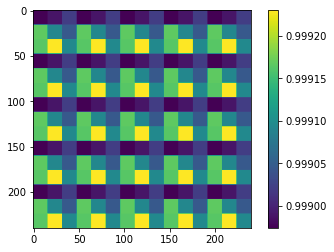

In [49]:
import matplotlib.pyplot as plt
plt.imshow(full_output[0, 0, :, :, 75]);
plt.colorbar();
# plt.hist(full_output[0, 0].flatten())

In [22]:
import napari
viewer = napari.view_image(full_output[0, 0], name="tumour core prediction probabilities")
for i in range(len(contrasts)):
    viewer.add_image(img[0, i, ...], name=test_id + '' + contrasts[i])

gt_layer = viewer.add_labels(ground_truth, name="ground truth")
pred_layer = viewer.add_labels(full_output.argmax(axis=1)[0], name="predicted classes")